In [1]:
import pandas as pd
import numpy as np

import util, plotting, analysis
%load_ext autoreload
%autoreload 2

# Data Characteristics
The primary dataset used for analysis in the following section contains 30 seconds of data recorded with an OxiWear prototype device attached to the ear (file: '20201012-180354-9697-6264.csv'). Reference SpO2 and heart rate readings were taken concurrently with a finger-attached pulse oximeter. In this 30 second window, the heart rate was 62-64 BMP and the SpO2 was 96-97% according to this reference. The data consist of a red LED (660 nm) signal and an infrared LED (940 nm) signal and were sampled continuously at 25Hz. 

The first step in the data processing is to decompose the red and infrared signals into AC and DC components. We did so using high-pass and low-pass Butterworth filters, respectively. Below is plotted the original infrared signal (top), the AC component (middle), and the DC component (bottom).


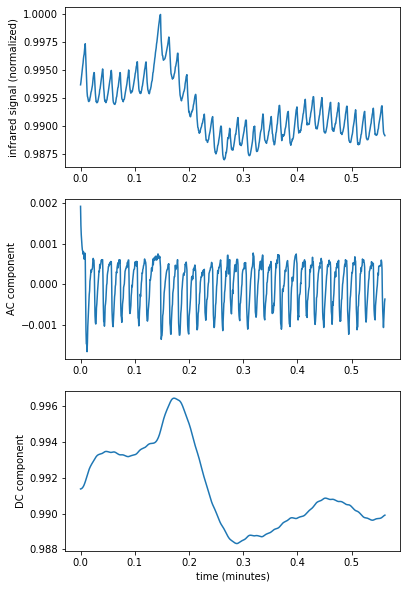

In [2]:
# Load and organize data

csv_data ='spo2-data/proto2/20201012-180354-9697-6264.csv' # 30 seconds


df = pd.read_csv(csv_data) # be aware that some files have a header
red = df['3']
infrared = df['1']
sampling_rate = 24.995
tile_range = [50, 773] # chosen to be approximately continuous when data are looped


data = util.decompose_ACDC(red, infrared, sampling_rate)
data = util.getSpO2(data)
plotting.plot_raw_data(data)


# Sampling frequency
First, we consider the ‘sampling frequency’ parameter: the rate at which LEDs flash and photodiodes collect data. The OxiWear device currently operates at a sampling rate of 25Hz, a typical choice for pulse oximeters. Yet, it is possible that a lower sampling frequency would be sufficient. The Nyquest-Shannon sampling theorem states that the minimum adequate frequency to reliably sample a signal is twice the highest frequency signal in the data. For example, to sample heart rate signals, one should sample at least at twice the highest conceivable heart rate (approximately 220 beats per minute), which would be approximately 440 samples per minute or about 8Hz. 

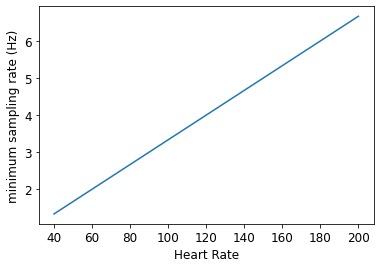

In [5]:
# Nyquest: minimum sampling rate vs heart rate
HR = np.linspace(40,200,200)
plotting.plot_nyquest(HR, 'Heart Rate')

The plot above shows the theoretically minimum sufficient sampling rate as a function of heart rate. While this theorem supplies a baseline for a minimally sufficient sampling rate, real-world factors such as noise may necessitate a higher sampling frequency. 


The appropriate sampling frequency will also depend on the heart rate (signal with lower heart rate can tolerate a lower sampling frequency). It is thus important to ensure the chosen sampling frequency retains accuracy across all potential heart rate values. Here, we employed synthetic data with heart rate ranging from 40 BPM to 220 BMP. We test a variety of sampling rates from 8Hz to 40Hz via linear interpolation.

**Q**: What is the minimum sampling frequency that will yield accurate heart rate measurement?\
**A**: It depends on the magnitude of heart rate. Assuming a maximum heart rate of 220 BPM, theoretically 7.33Hz would be sufficient.

In [10]:
target_HRs = np.arange(40,220,10)
resampled_rates = np.arange(8,51,2)
original_data = -np.tile(data['red_AC'][16:],2) # approx 1 minute of data
original_fq = data['sampling_rate']

error, means, stds = analysis.samplingFq_vs_HR(original_data, original_fq, target_HRs, resampled_rates)
pct_error = (error/means)*100

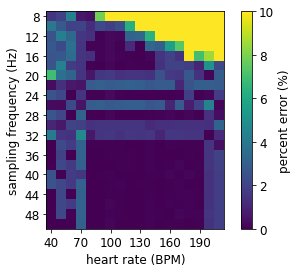

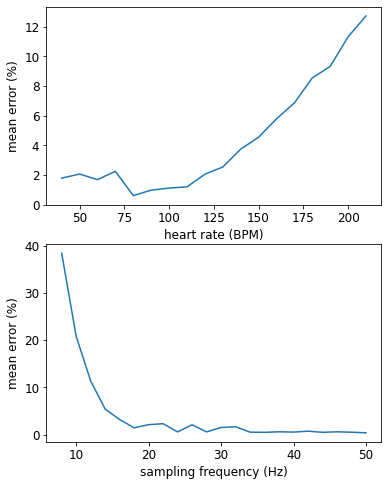

In [12]:
#  plot means
plotting.plot_fq_vs_HR(pct_error, target_HRs, resampled_rates)

Plotted above is the percent error in the estimation of heart rate across heart rate magnitude and sampling frequency. At the top is a heatmap where the color indicates percent error and at the bottom are the same results marginalized across either sampling frequency (top) or heart rate (bottom). As expected, high heart rates (>100BPM)  are subject to error, particularly when sampling frequency is low (<12Hz). However, measurement error stabilizes below 2.5% error by 18Hz suggesting that ~18Hz is sufficient and higher sampling rates do not improve signal reliability.

**Q**: Given empirical data, what is the minimum sampling frequency that will yield accurate heart rate measurement?\
**A**: A sampling rate of 18Hz is sufficient to measure heart rate with less than 2.5% error at all viable heart rate magnitudes. Increasing sampling beyond 18Hz doesn't improve accuracy significantly.

# Sample Duration

Next, we consider the duration of a data sample needed to accurately calculate heart rate. Particularly when the heart rate is slow, a sufficiently long sample is needed to calculate heart rate accurately. For example, if the heart rate is 60 BPM, a one second sample would only capture 1 heart beat and would be too short a duration to calculate heart rate.

In [13]:
sample_durs = [1,2,3,4,5,6,7,8,9,10,15,30,45,60]
error, means, stds = analysis.samplingDur_vs_HR(original_data, original_fq, target_HRs, sample_durs)
pct_error = (error/means)*100

/opt/anaconda3/envs/CS230/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/CS230/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


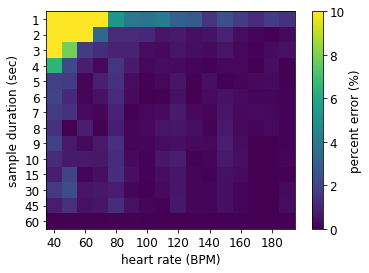

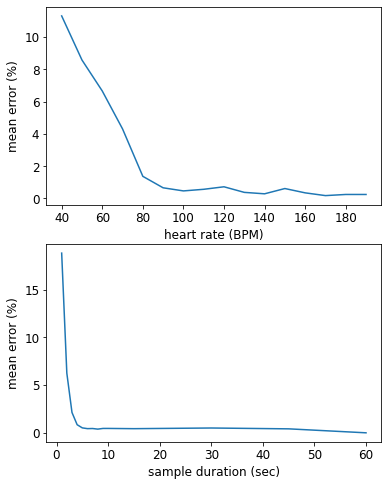

In [20]:
#  plot means
plotting.plot_dur_vs_HR(pct_error, target_HRs, sample_durs)


Plotted above is the percent error in the estimation of heart rate across heart rate magnitude and sample duration. At the top is a heatmap where the color indicates percent error and at the bottom are the same results marginalized across either sample duration (top) or heart rate (bottom). Again as expected, lower heart rates (<80 BPM) are subject to error, particularly when sample duration is low (<4 seconds). Measurement error stabilizes below 1% error by 4 seconds, indicating that a very brief sample duration is sufficient to accurately calculate heart rate.

**Q**: For how long a period do data need to be collected to accurately measure heart rate?\
**A**: 6 seconds of data is sufficient to accurately measure heart rate across all viable heart rate magnitudes.

# Data Update Period

Here, we will consider the ‘data update period’: the frequency at which the device is collecting data. The Oxiwear device currently collects data continuously and at all times. By contrast, other competing devices that measure blood oxygen do so much less frequently (e.g. once per 10 minutes or on-demand). While these much lower data collection rates yield excellent battery life, such infrequent data updates would render these devices ineffective for medical use. A device intended for medical use, such as OxiWear, must report blood oxygen frequently enough to inform the user if their levels drop dangerously. While a continuous data collection strategy meets this need, it is energy inefficient. 

We have shown that very brief sample durations (~4 seconds) are sufficient to calculate heart rate. Thus, it may be possible to collect data in brief bouts, rather than continuously, for a dramatic energy savings.

To address this question, we rely on the time-course of hypoxic episodes observed in the literature.

In [286]:
# battery calculations

# original_fq = data['sampling_rate']
original_N = data['sampling_rate']*60

results = np.zeros((len(resampled_rates),len(sample_durs)))
for idx,dur in enumerate(sample_durs):
    for idx2, new_fq in enumerate(resampled_rates):
        this_N = new_fq*dur
        results[idx2,idx] = 100*(this_N/original_N)

plt.imshow(results.T)

locs, labels = plt.xticks()
ax = plt.gca()
x_idx = np.arange(0,len(resampled_rates),2)
ax.set_xticks(x_idx)
ax.set_xticklabels(resampled_rates[x_idx])

y_idx = np.arange(0,len(sample_durs),1)
ax.set_yticks(y_idx)
ax.set_yticklabels(np.array(sample_durs)[y_idx].T)
plt.colorbar()
plt.show()

In [29]:
from scipy import signal, interpolate
import matplotlib.pyplot as plt

# function to synthesze a spo2 drop, operates on DC signal

def synthesize_drop(DC_synth, sampling_rate, params, drop_idx, low_pass):
    
    drop_time_sec = params['drop_time_sec']
    recover_time_sec = params['recover_time_sec']
    drop_frac = params['drop_frac']
    
    drop_time    = int(drop_time_sec*sampling_rate)
    recover_time = int(recover_time_sec*sampling_rate)
    T_kernel = drop_time + recover_time


    buffer = 1000
    drop_kernel = np.ones(T_kernel+buffer*2)
    drop_kernel[buffer:drop_time+buffer] = np.linspace(1,params['drop_frac'] , drop_time)
    drop_kernel[drop_time+buffer:drop_time+buffer+recover_time]  = np.linspace(params['drop_frac'] ,1, recover_time)
    drop_kernel = signal.sosfilt(low_pass, drop_kernel)
    drop_kernel = drop_kernel[buffer:buffer+T_kernel]
    T_kernel = len(drop_kernel)
    
    DC_synth_drop = DC_synth
    DC_synth_drop[drop_idx:drop_idx+T_kernel] = DC_synth[drop_idx:drop_idx+T_kernel]*drop_kernel

    return DC_synth_drop

def zscore(data):
    return (data-np.mean(data))/np.std(data)


def synthesize_SpO2(h, tile_range, params, simulation_dur_sec = 60*60):
    
    red = h['red']
    IR = h['IR']
    sampling_rate = h['sampling_rate']
    low_pass = h['low_pass']
    
    
    
    synth_ratio = (params['baseline_spo2']-120)/-40 
    
    
    data_dur_sec = (tile_range[1]-tile_range[0])/sampling_rate
    num2tile = int(simulation_dur_sec/data_dur_sec)
    
    #####---------------------------------------------------####
    def synthesize_data(data_AC, data_DC, drop):
       
        
        data_AC = data_AC[tile_range[0]:tile_range[1]]
        AC_synth = np.tile(data_AC, num2tile) 
        AC_synth = zscore(AC_synth)*100
        N = len(AC_synth)
        
#         data_DC = data_DC[tile_range[0]:tile_range[1]]
#         DC_synth = np.tile(data_DC, num2tile) 
#         DC_synth = DC_synth + np.random.rand(N)*np.std(data_DC)
        DC_synth = np.ones(N)*100
#         DC_synth = np.mean(data_DC)*100 + np.random.rand(N)*np.std(data_DC)
#         DC_synth = np.concatenate((np.zeros(200), DC_synth))
#         DC_synth = signal.sosfilt(low_pass, DC_synth)
#         DC_synth = zscore(DC_synth[200:])*100
        
        # mimic spo2 drop
        if drop:
            drop_time    = int(params['drop_time_sec']*sampling_rate)
            recover_time = int(params['recover_time_sec']*sampling_rate)
            kernel_duration = drop_time + recover_time

            drop_idx = np.random.randint(3*sampling_rate, N-(kernel_duration))
            DC_synth = synthesize_drop(DC_synth, sampling_rate, params, drop_idx, low_pass)
        else:
            drop_idx = float('nan')

        
        return AC_synth, DC_synth, drop_idx
    #####---------------------------------------------------####
    
    IR_AC_synth,  IR_DC_synth, _  = synthesize_data(h['IR_AC'],  h['IR_DC'], False)
    red_AC_synth, red_DC_synth, drop_idx = synthesize_data(h['red_AC'], h['red_DC'], True)
    
    data_synth = dict()
    data_synth['red'] = red_AC_synth + red_DC_synth
    data_synth['IR'] = IR_AC_synth + IR_DC_synth
    data_synth['red_AC'] = red_AC_synth
    data_synth['red_DC'] = red_DC_synth
    data_synth['IR_AC'] = IR_AC_synth
    data_synth['IR_DC'] = IR_DC_synth*synth_ratio
    data_synth['sampling_rate'] = sampling_rate
    data_synth['drop_idx'] = drop_idx
    data_synth['time_min'] = np.linspace(0,len(red_AC_synth)/sampling_rate,len(red_AC_synth))/60
    
    data_synth = util.getSpO2(data_synth)
    
    
    return data_synth

def plot_kernel(params, sampling_rate):
    N = int((params['drop_time_sec'] + params['recover_time_sec'])* sampling_rate * 2)
    kernel = np.ones(N)

    drop_time    = int(params['drop_time_sec']*sampling_rate)
    recover_time = int(params['recover_time_sec']*sampling_rate)
    kernel_duration = drop_time + recover_time
    drop_idx = np.random.randint(4*sampling_rate,N-(kernel_duration))
    low_pass = data['low_pass']

    kernel = synthesize_drop(kernel, sampling_rate, params, drop_idx, low_pass)
    kernel_filtered = signal.sosfilt(low_pass, kernel)
    t = np.linspace(0, N/(sampling_rate*60),N)
    t = t-(drop_idx/(sampling_rate*60))
    
    plt.plot(t[120:], kernel_filtered[120:])
    ax = plt.gca()
    ax.set_ylim(0,1.1)    

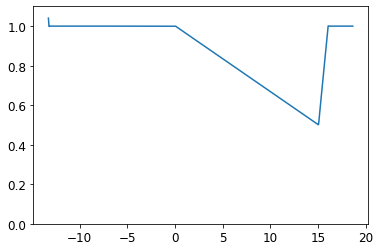

In [31]:
# generate synthetic data

#  shunt PPH case
params = dict()
params['baseline_spo2'] = 90
params['drop_time_sec'] = 1*60
params['recover_time_sec'] = 20*60
params['drop_frac'] = 0.6
simulation_dur_sec = 30*60

#  no-shunt-PPH
params = dict()
params['baseline_spo2'] = 80
params['drop_time_sec'] = 15*60
params['recover_time_sec'] = 3*20
params['drop_frac'] = 0.5
simulation_dur_sec = 30*60

data_synth = synthesize_SpO2(data, tile_range, params, simulation_dur_sec = simulation_dur_sec)
plot_kernel(params, sampling_rate)

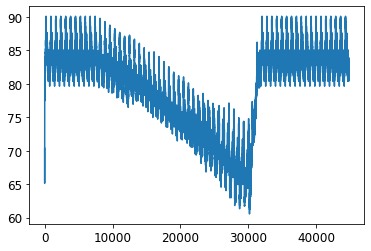

In [30]:



plt.plot(data_synth['spo2'])